## Apriori Principle: (To Reduce the number of candidates)

**If an itemset is frequent, then all of its subsets must also be frequent.**
Apriori principle holds due to the property of the support measure

- support of an itemset never exceeds the support of its subsets == Antimonotone property of support

2 Implications of Anti-Monotone Property:
1. Any subset of a frequent itemset must also be frequent.
i.e. any transaction containing {beer, diaper, milk} also contains {neer, diaper}

2. Any superset of an infrequent itemset must also be infrequent
- no superset of any infrequent itemset shoudl be generated or tested
--> many item combinations can be pruned in this way.



(online reference https://www.kaggle.com/code/bismakhan08/apriori-algorithm-from-scratch)

### Apriori Algorithm
F_k = frequent k-itemseets (containing k items)
C_k = candidate k-itemsets

Algorithm
- let k = 1
- generate F_1 = {frequent 1-itemsets}
- repeat until F_k is empty
--> Candidate Generation: Generate C_k+1 from F_k
--> Candidate Pruning: Prune candidate itemsets in C_k+1 containing subsets of length k that are infrequent
--> Support Counting: Count support of each candidate in C_k+1 by scanning the database
--> Candidate Elimination: Eliminate candidates in C_k+1 that are infrequent, leaving only those that are frequent --> F_k+1


Algorithm Implementation:

Pass 1:
- read baskets and count in main memory the occurrences of each indiviual item
Pass 2:
- read baskets again and count in main memory only those pairs where both elements are frequent (from Pass 1)


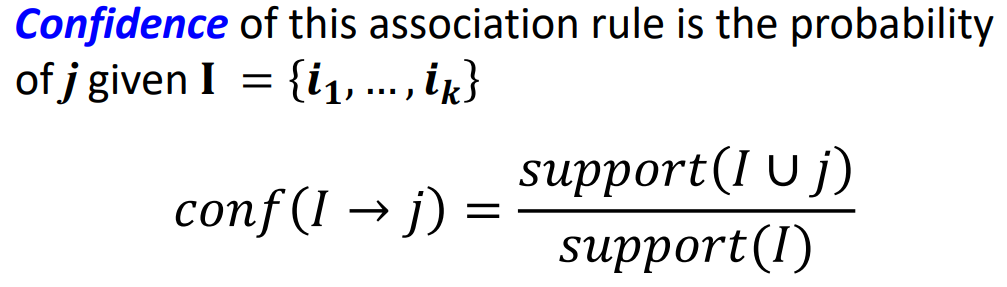

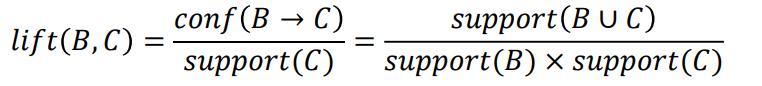

In [1]:
import pandas as pd
import numpy as np
import math
import csv

Using the example from the lecture notes
Slide: Example: Apriori-based Mining

In [2]:
# a = 'apple'
# b = 'banana'
# c = 'carrot'
# d = 'durian'
# e = 'edamame'
txn_dict = {'10' : 'apple,carrot,durian', '20': 'banana,carrot,edamame', '30':'apple,banana,carrot,edamame', '40': 'banana,edamame'}
trans_df=pd.DataFrame.from_dict(txn_dict,orient='index')

In [3]:
trans_df = trans_df[0].str.split(',')

In [4]:
trans_df

10             [apple, carrot, durian]
20           [banana, carrot, edamame]
30    [apple, banana, carrot, edamame]
40                   [banana, edamame]
Name: 0, dtype: object

In [5]:
def prune(data,supp):
    df = data[data.supp_count >= supp]
    return df

def count_itemset(transaction_df, itemsets):

    count_item = {}
    for item_set in itemsets:
        set_A = set(item_set)
        for row in trans_df:
            set_B = set(row)

            if set_B.intersection(set_A) == set_A:
                if item_set in count_item.keys():
                    count_item[item_set] += 1

                else:
                    count_item[item_set] = 1

    data = pd.DataFrame()
    data['item_sets'] = count_item.keys()
    data['supp_count'] = count_item.values()
    print("Candidate itemset table (Counting):\n", data)
    return data

def count_item(trans_items):

    count_ind_item = {}
    for row in trans_items:
        for i in range(len(row)):
            if row[i] in count_ind_item.keys():
                count_ind_item[row[i]] += 1
            else:
                count_ind_item[row[i]] = 1

    data = pd.DataFrame()
    data['item_sets'] = count_ind_item.keys()
    data['supp_count'] = count_ind_item.values()
    data = data.sort_values('item_sets')

    return data


def join(list_of_items):
    itemsets = []
    i = 1
    for entry in list_of_items:
        proceding_items = list_of_items[i:]
        for item in proceding_items:
            if(type(item) is str):
                if entry != item:
                    tuples = (entry, item)
                    itemsets.append(tuples)
            else:
                if entry[0:-1] == item[0:-1]:
                    tuples = entry+item[1:]
                    itemsets.append(tuples)
        i = i+1
    if(len(itemsets) == 0):
        return None
    return itemsets

In [6]:
def apriori(trans_data,supp=2):
    freq = pd.DataFrame()

    df = count_item(trans_data)

    while(len(df) != 0):

        df = prune(df, supp)
        print("Minsup =", supp,"\n")
        print("Freq itemset table (Pruned):\n", df)

        if len(df) > 1 or (len(df) == 1 and int(df.supp_count >= supp)):
            freq = df

        itemsets = join(df.item_sets)

        if(itemsets is None):
            return freq

        df = count_itemset(trans_data, itemsets)
    return df

In [7]:
freq_item_sets = apriori(trans_df, 2)
freq_item_sets

Minsup = 2 

Freq itemset table (Pruned):
   item_sets  supp_count
0     apple           2
3    banana           3
1    carrot           3
4   edamame           3
Candidate itemset table (Counting):
            item_sets  supp_count
0    (apple, banana)           1
1    (apple, carrot)           2
2   (apple, edamame)           1
3   (banana, carrot)           2
4  (banana, edamame)           3
5  (carrot, edamame)           2
Minsup = 2 

Freq itemset table (Pruned):
            item_sets  supp_count
1    (apple, carrot)           2
3   (banana, carrot)           2
4  (banana, edamame)           3
5  (carrot, edamame)           2
Candidate itemset table (Counting):
                    item_sets  supp_count
0  (banana, carrot, edamame)           2
Minsup = 2 

Freq itemset table (Pruned):
                    item_sets  supp_count
0  (banana, carrot, edamame)           2


/var/folders/ll/h2ldzwfj6kl5qkxyrsrp33p80000gn/T/ipykernel_38048/4225792083.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if len(df) > 1 or (len(df) == 1 and int(df.supp_count >= supp)):


,item_sets,supp_count
0,"(banana, carrot, edamame)",2


In [8]:
def calculate_conf(value1, value2):
    return round(int(value1)/int(value2) * 100, 2)

In [9]:
def strong_rules(freq_item_sets, threshold):

    confidences = {}
    for row in freq_item_sets.item_sets:
        for i in range(len(row)):
            for j in range(len(row)):
                 if i != j:
                    tuples = (row[i], row[j])
                    conf = calculate_conf(freq_item_sets[freq_item_sets.item_sets == row].supp_count, count_item(trans_df)[count_item(trans_df).item_sets == row[i]].supp_count)
                    confidences[tuples] = conf


    conf_df = pd.DataFrame()
    conf_df['item_set'] = confidences.keys()
    conf_df['confidence'] = confidences.values()

    return conf_df[conf_df.confidence >= threshold]

In [10]:
strong_rules(freq_item_sets, 0.75)

/var/folders/ll/h2ldzwfj6kl5qkxyrsrp33p80000gn/T/ipykernel_38048/3254531325.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return round(int(value1)/int(value2) * 100, 2)
/var/folders/ll/h2ldzwfj6kl5qkxyrsrp33p80000gn/T/ipykernel_38048/3254531325.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return round(int(value1)/int(value2) * 100, 2)
/var/folders/ll/h2ldzwfj6kl5qkxyrsrp33p80000gn/T/ipykernel_38048/3254531325.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return round(int(value1)/int(value2) * 100, 2)
/var/folders/ll/h2ldzwfj6kl5qkxyrsrp33p80000gn/T/ipykernel_38048/3254531325.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future

,item_set,confidence
0,"(banana, carrot)",66.67
1,"(banana, edamame)",66.67
2,"(carrot, banana)",66.67
3,"(carrot, edamame)",66.67
4,"(edamame, banana)",66.67
5,"(edamame, carrot)",66.67


In [21]:
def create_feature_matrix(transactions, frequent_itemsets):
    feature_matrix = []
    for transaction in transactions:
        feature_vector = []
        for itemset in frequent_itemsets:
            itemset = list(itemset)
            if set(itemset).issubset(set(transaction)):
                print(f"Itemset {itemset} in transaction {transaction}")
                feature_vector.append(1)
            else:
                print(f"Itemset {itemset} not in transaction {transaction}")
                feature_vector.append(0)
        feature_matrix.append(feature_vector)
    return feature_matrix

create_feature_matrix(transactions=trans_df.values, frequent_itemsets=freq_item_sets['item_sets'].values)

Itemset ['banana', 'carrot', 'edamame'] not in transaction ['apple', 'carrot', 'durian']
Itemset ['banana', 'carrot', 'edamame'] in transaction ['banana', 'carrot', 'edamame']
Itemset ['banana', 'carrot', 'edamame'] in transaction ['apple', 'banana', 'carrot', 'edamame']
Itemset ['banana', 'carrot', 'edamame'] not in transaction ['banana', 'edamame']


[[0], [1], [1], [0]]

In [27]:
import itertools
# generate all combinations of items in a list
def generate_all_permutations(freq_item_sets):
    all_permutations = []
    for itemset in freq_item_sets['item_sets'].values:
        itemset = list(itemset)
        for i in range(1, len(itemset)):
            all_permutations.append(list(itertools.combinations(itemset, i)))
    return all_permutations

generate_all_permutations(freq_item_sets)

[[('banana',), ('carrot',), ('edamame',)],
 [('banana', 'carrot'), ('banana', 'edamame'), ('carrot', 'edamame')]]

In [12]:
freq_item_sets

,item_sets,supp_count
0,"(banana, carrot, edamame)",2


In [164]:
from functools import reduce # Valid in Python 2.6+, required in Python 3
import operator

def interesting_rules(freq_item_sets):

    lifts = {}
    prob_of_items = []

    for row in freq_item_sets.item_sets:
        num_of_items = len(row)

        prob_all = freq_item_sets[freq_item_sets.item_sets == row].supp_count / 18
        for i in range(num_of_items):
            prob_of_items.append(count_item(trans_df)[count_item(trans_df).item_sets == row[i]].supp_count / 18)

        lifts[row] = round(float(prob_all / reduce(operator.mul, (np.array(prob_of_items)), 1)), 2)

        prob_of_items = []


    lifts_df = pd.DataFrame()
    lifts_df['Rules'] = lifts.keys()
    lifts_df['lift'] = lifts.values()

    return lifts_df

In [165]:
int_rules = interesting_rules(freq_item_sets)
int_rules

,Rules,lift
0,"(banana, carrot, edamame)",24.0


# To show the result of the Apriori algorithm implemented is correct